In [1]:
import os
import numpy as np
import pandas as pd
import csv
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, norm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, RandomOverSampler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = []    
f = open("HighAndLowFeatures(edited).csv","r")
d_reader = csv.reader(f,delimiter=",",quotechar="\"")
first = True
for line in d_reader:
    if first:
        first = False
        continue
    data.append(line)
print(np.shape(data))

(267, 343)


In [3]:
x_train = np.empty((0,339))
y_train = np.array([])

for line in data:
    x_train = np.append(x_train,np.array(list(map(float,line[1:-3]))).reshape((1,339)),axis=0)
    y_train = np.append(y_train,int(line[-1]))
print(x_train.shape)
print(y_train.shape)
#print(y_train)

(267, 339)
(267,)


In [4]:
rand_seed = 3454132

oversampler = SMOTE(sampling_strategy="not majority",random_state=rand_seed)

x_smote, y_smote = oversampler.fit_resample(x_train,y_train)

print(x_smote.shape,y_smote.shape)

oversampler = RandomOverSampler(sampling_strategy="not majority",random_state=rand_seed)

x_os, y_os = oversampler.fit_resample(x_train,y_train)

print(x_os.shape,y_os.shape)

(480, 339) (480,)
(480, 339) (480,)


In [5]:
"""
Trains a model using the given data and a hyperparameter search object

Parameters:
x_train - input data
y_train - target labels for data
hp_search - model_selection object

Returns: best estimator for the given data given the model selector
"""
def train_model(x_train,y_train,hp_search):
    hp_search.fit(x_train,y_train)
    print("Best Score: {:.4f}".format(hp_search.best_score_))
    for k,v in hp_search.best_params_.items():
        print("{} => {}".format(k,v))
    print("Splits: {}".format(hp_search.n_splits_))
    y_out = hp_search.predict(x_train)
    print("Accuracy: {:.4f}%".format(np.mean(y_out == y_train) * 100.0))
    return hp_search.best_estimator_

In [6]:
#DecisionTree
random_search_iterations = 1000

parameters = {
    'criterion':["gini", "entropy"], 
    'splitter':["best", "random"], 
    'max_depth':range(1, 10), 
    'min_samples_split':uniform(loc=0,scale=1.0)
}

# train classifier for SMOTE data
dt = tree.DecisionTreeClassifier()
rscv = RandomizedSearchCV(dt, parameters,cv=10, n_iter=random_search_iterations,n_jobs=-1)

Random Oversampling:
Best Score: 0.6750
criterion => gini
max_depth => 9
min_samples_split => 0.0035686081779829903
splitter => best
Splits: 10
Accuracy: 93.1250%


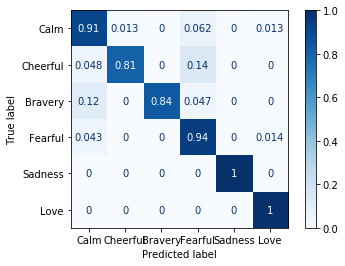

In [7]:
print("Random Oversampling:")
train_model(x_os,y_os,rscv)

# display confusion matrix
disp = plot_confusion_matrix(rscv, x_train, y_train,
                             display_labels=["Calm","Cheerful","Bravery","Fearful","Sadness","Love"],
                             cmap=plt.cm.Blues,
                             normalize='true')
# print(y_out)

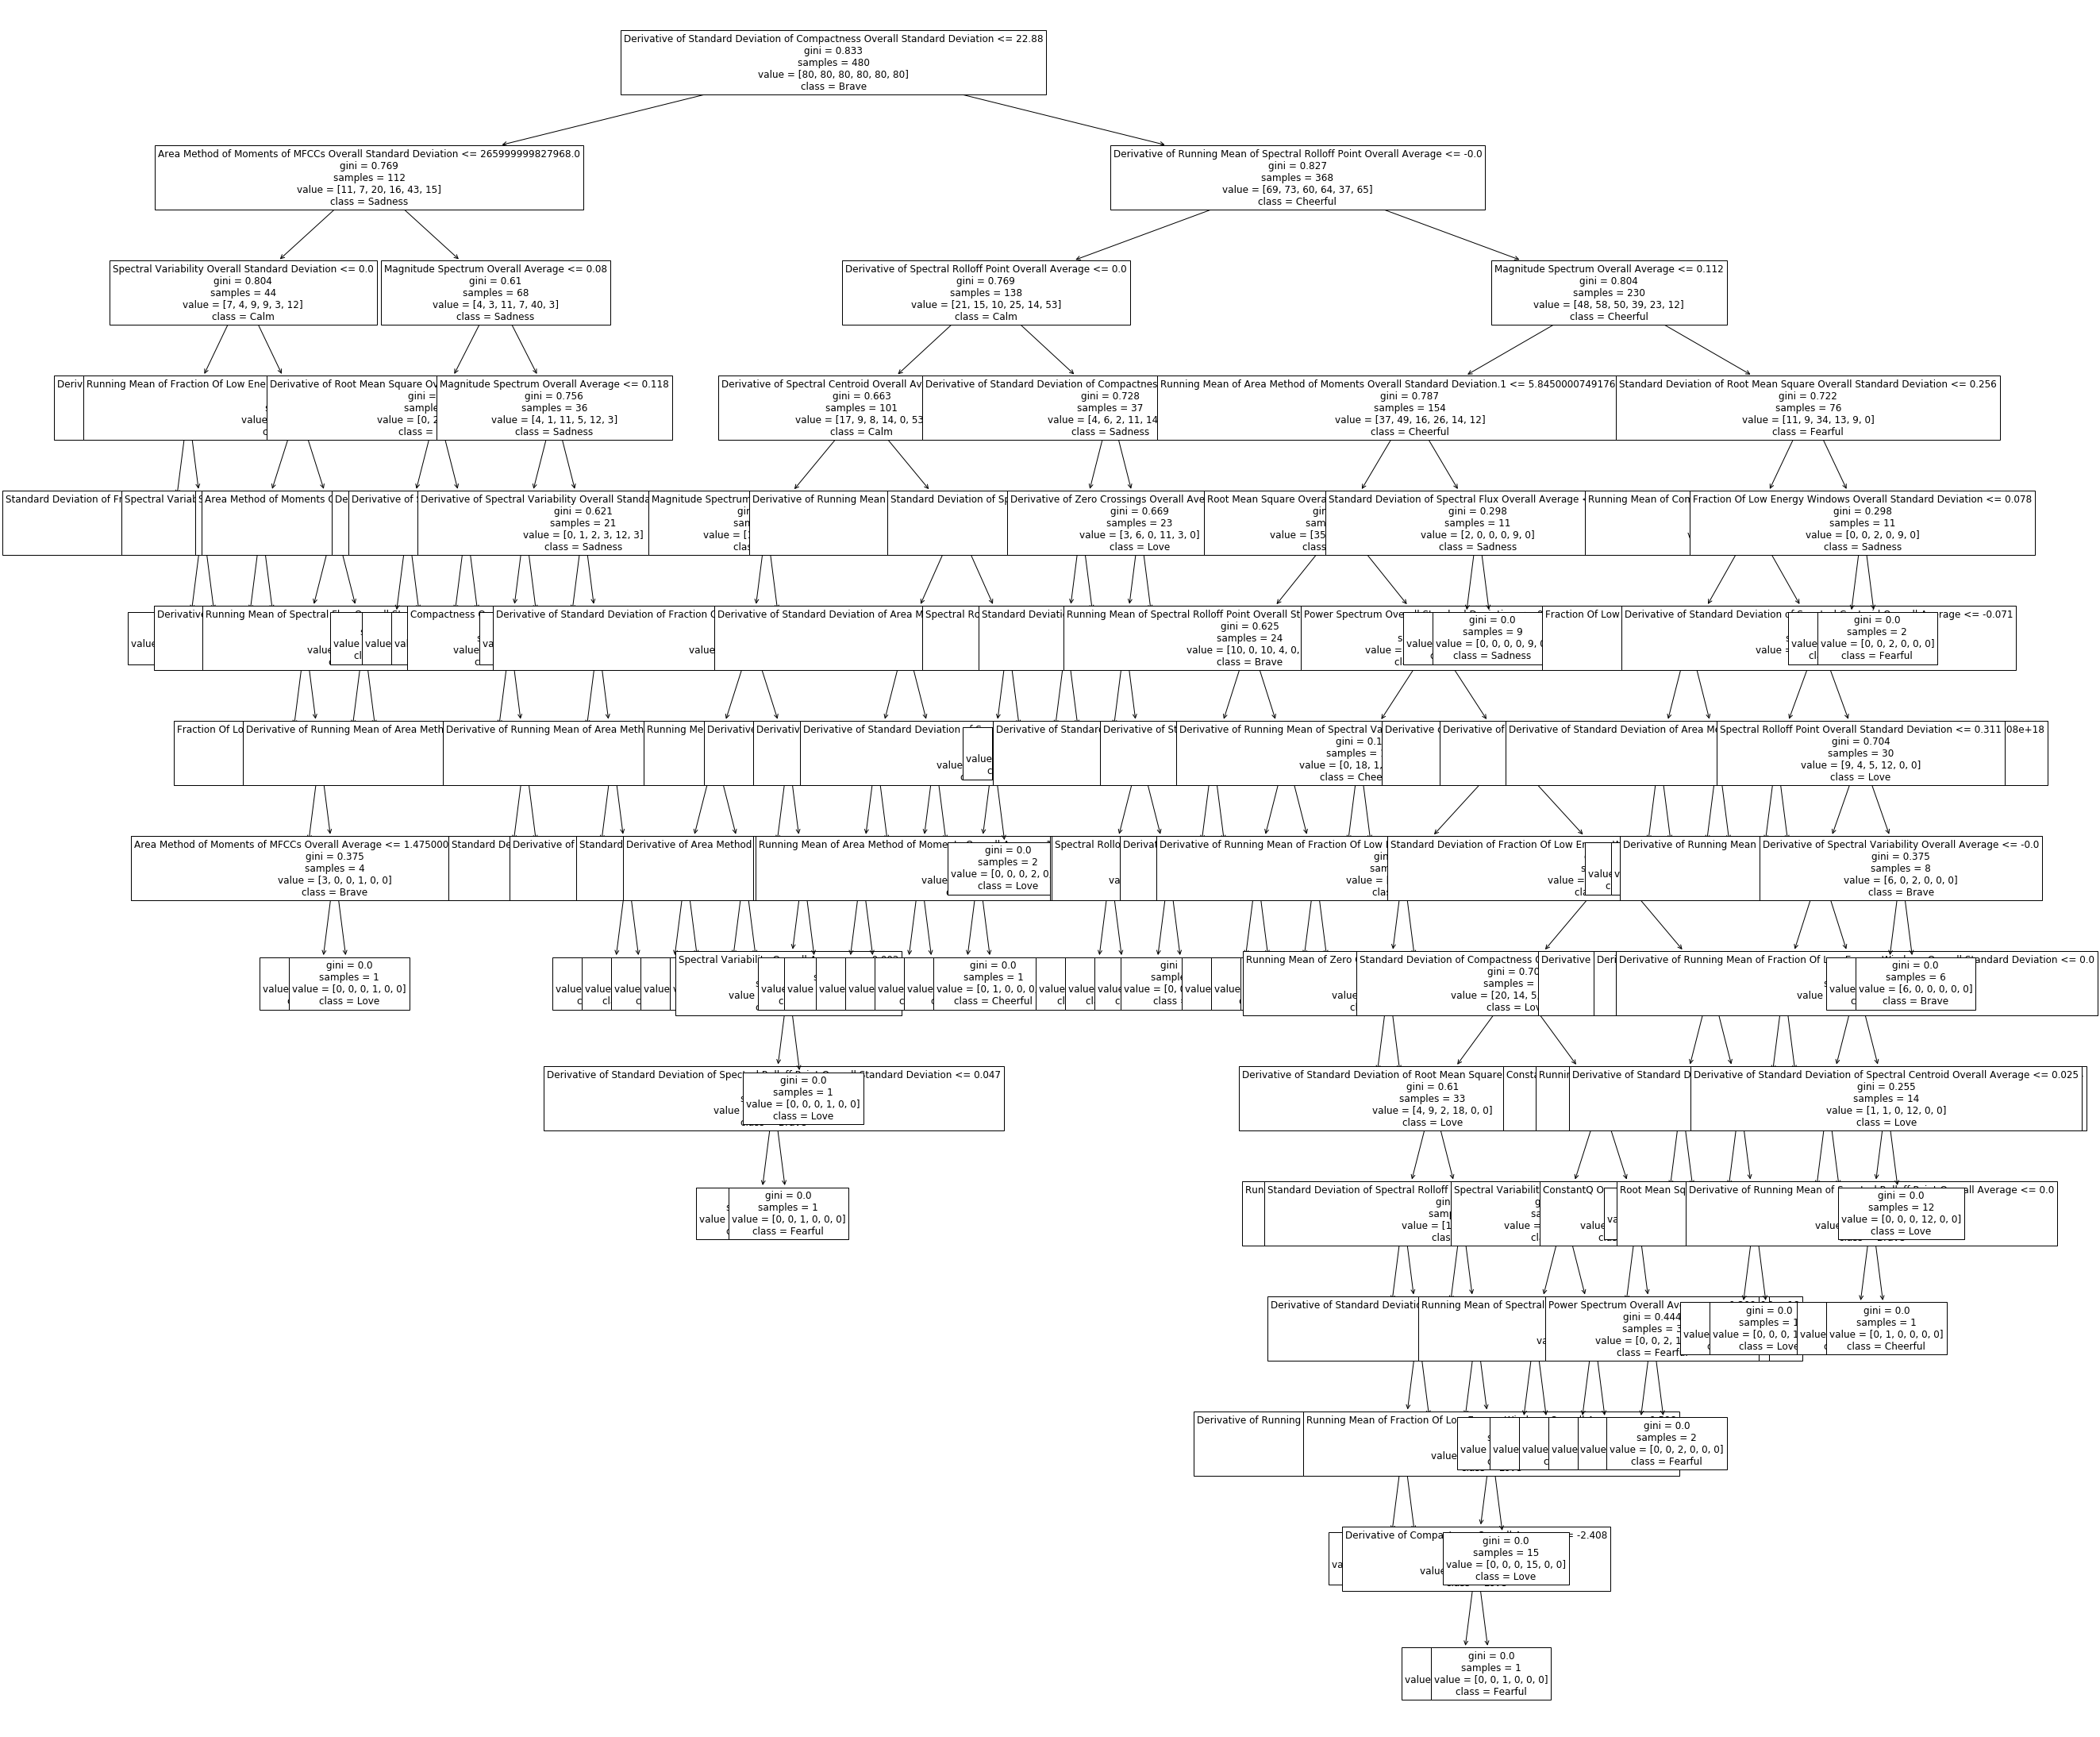

In [12]:
# Display Tree
classes = ['Brave', 'Cheerful', 'Fearful', 'Love', 'Sadness', 'Calm']
dt.fit(x_os,y_os)
file = pd.read_csv("HighAndLowFeatures(edited).csv")
features = list(file)
fig, ax = plt.subplots(figsize=(40, 40))
treefig = tree.plot_tree(dt, class_names=classes, feature_names=features[1:-3], fontsize=12, ax=ax)
plt.show()

SMOTE:
Best Score: 0.4813
criterion => gini
max_depth => 9
min_samples_split => 0.004186121686119426
splitter => best
Splits: 10
Accuracy: 91.8750%


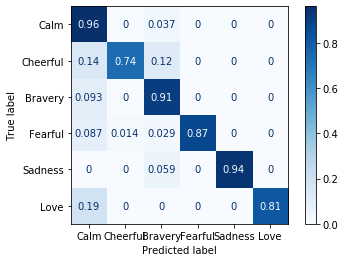

In [9]:
print("SMOTE:")
train_model(x_smote,y_smote,rscv)

# display confusion matrix
disp = plot_confusion_matrix(rscv, x_train, y_train,
                             display_labels=["Calm","Cheerful","Bravery","Fearful","Sadness","Love"],
                             cmap=plt.cm.Blues,
                             normalize='true')
# print(y_out)

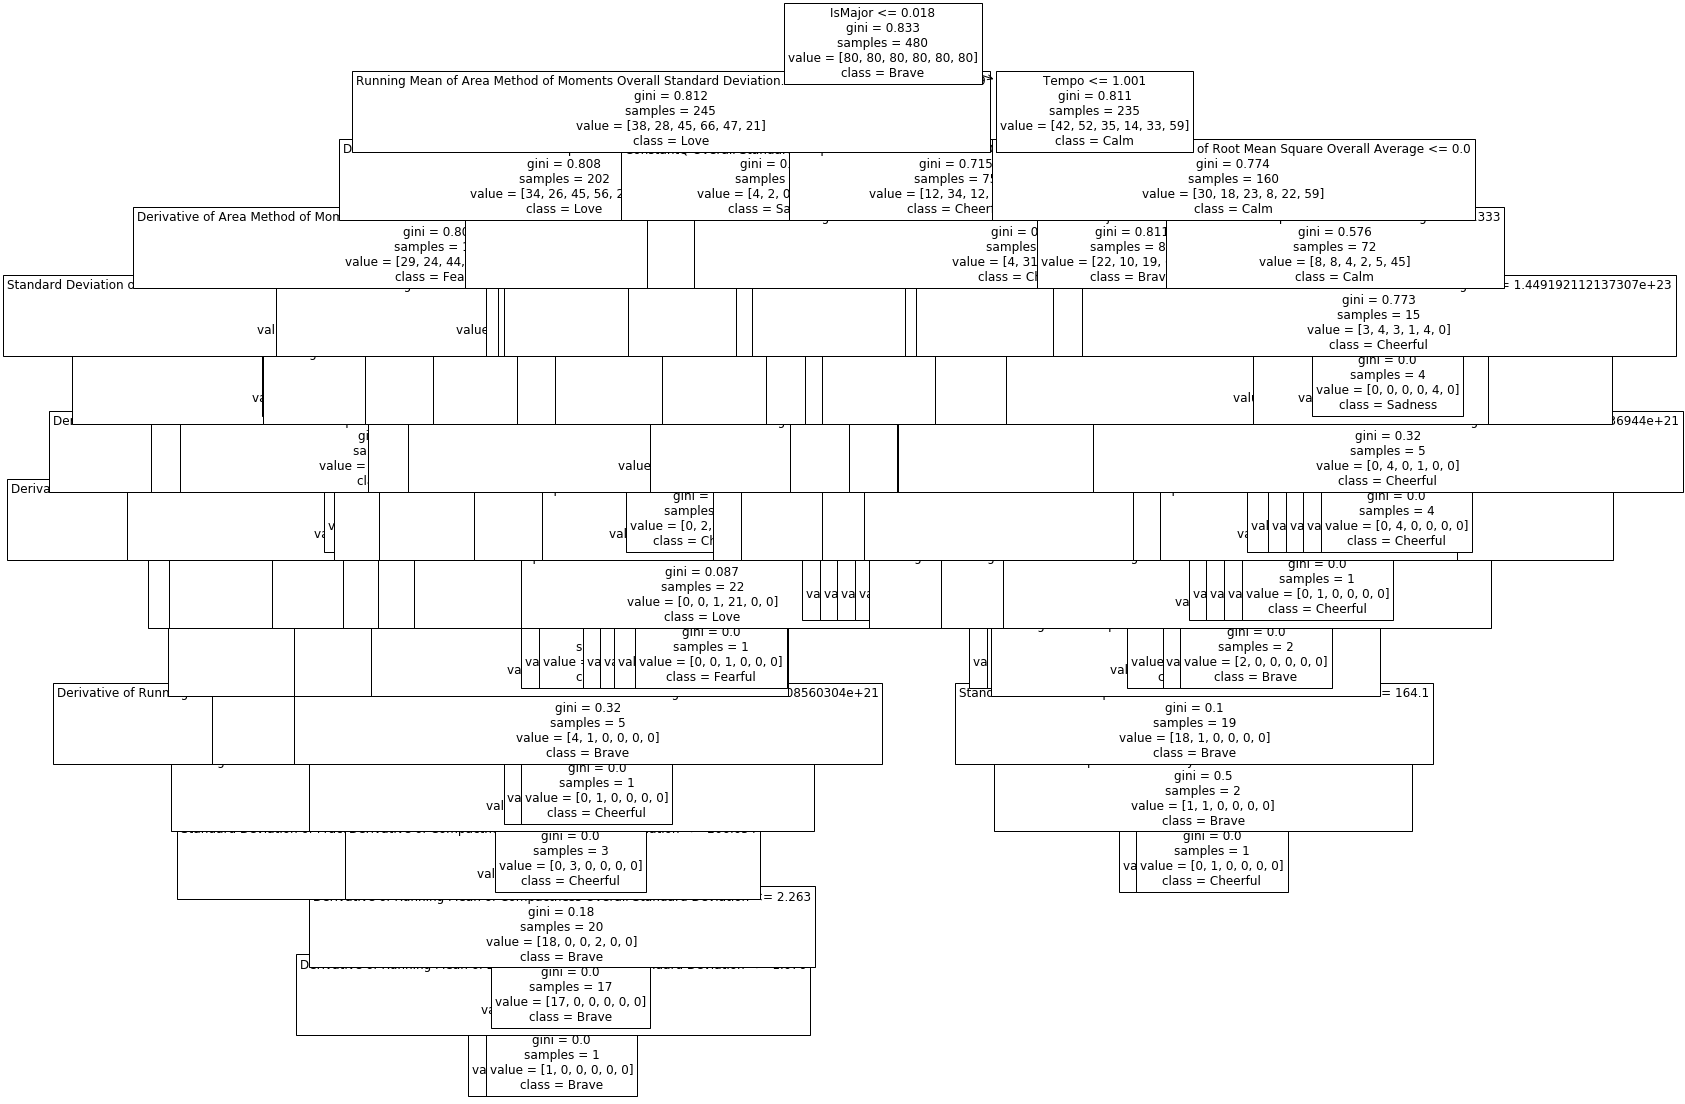

In [11]:
# Display Tree
classes = ['Brave', 'Cheerful', 'Fearful', 'Love', 'Sadness', 'Calm']
dt.fit(x_smote,y_smote)
file = pd.read_csv("HighAndLowFeatures(edited).csv")
features = list(file)
fig, ax = plt.subplots(figsize=(20, 20))
treefig = tree.plot_tree(dt, class_names=classes, feature_names=features[1:-3], fontsize=12, ax=ax)
plt.show()